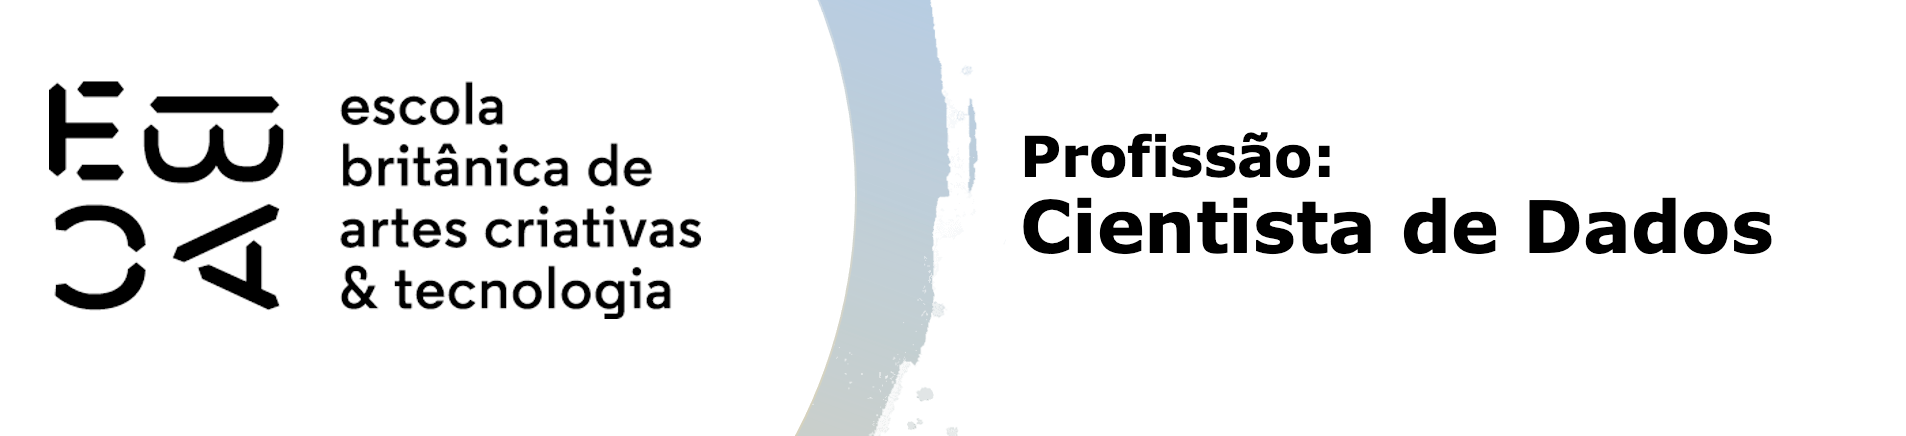

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 

import warnings
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv('./input/previsao_de_renda_II.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          624240 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [33]:
def sample(data: pd.DataFrame, column: str, perc: float = 1, seed: int = None) -> pd.DataFrame:
    if not (0 < perc <= 1):
        raise ValueError("O parâmetro perc deve estar entre 0 e 1.")

    if column not in data.columns:
        raise KeyError(f"A coluna '{column}' não existe no DataFrame.")

    novo_df = (data.groupby(by=column, group_keys=False)
                 .apply(lambda x: x.sample(frac=perc, random_state=seed))
                 .reset_index(drop=True))
    
    print(f"Df original:\n{data.groupby(by=column).size()}\nTotal para 100% dos dados: {len(data)} linhas\n")
    print(f"Novo df:\n{novo_df.groupby(by=column).size()}\nTotal para {perc:.1%} dos dados: {len(novo_df)} linhas\n")
    
    return novo_df


In [34]:
df_ = df.copy()
df_["renda_log"] = np.log(df_["renda"])
df_ = sample(data=df_, column="data_ref", perc=0.01, seed=420)
df_

Df original:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
dtype: int64
Total para 100% dos dados: 750000 linhas

Novo df:
data_ref
2015-01-01    500
2015-02-01    500
2015-03-01    500
2015-04-01    500
2015-05-01    500
2015-06-01    500
2015-07-01    500
2015-08-01    500
2015-09-01    500
2015-10-01    500
2015-11-01    500
2015-12-01    500
2016-01-01    500
2016-02-01    500
2016-03-01    500
dtype: int64
Total para 1.0% dos dados: 7500 linhas



,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log
0,2015-01-01,1282,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,9935.03,9.203822
1,2015-01-01,2327,F,S,S,0,Empresário,Médio,Casado,Casa,47,5.528767,2.0,10665.10,9.274732
2,2015-01-01,10923,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,12.526027,1.0,15899.37,9.674035
3,2015-01-01,12741,M,S,S,0,Assalariado,Superior completo,Separado,Casa,40,1.945205,1.0,3442.69,8.144008
4,2015-01-01,13061,F,N,N,0,Empresário,Médio,Casado,Governamental,50,4.676712,2.0,1619.86,7.390095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,2016-03-01,2155,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,32,0.841096,1.0,1263.60,7.141720
7496,2016-03-01,15731,F,N,S,0,Empresário,Superior completo,Solteiro,Casa,50,6.687671,1.0,850.94,6.746342
7497,2016-03-01,13989,F,S,N,1,Servidor público,Superior completo,Casado,Casa,38,14.712329,3.0,18671.61,9.834759
7498,2016-03-01,14883,F,S,N,0,Assalariado,Superior completo,Solteiro,Casa,55,2.800000,1.0,638.82,6.459623


In [35]:
df_.fillna(value={"tempo_emprego": df_.tempo_emprego.mean()}, inplace=True)
df_.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
renda_log                0
dtype: int64

In [36]:
df_train, df_test = train_test_split(df_, test_size=.2, random_state=420)

print(df_train.shape)
print(df_test.shape)

(6000, 15)
(1500, 15)


In [37]:
smf.ols(formula="renda_log ~ tempo_emprego", data=df_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     3414.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:57:35   Log-Likelihood:                -8676.6
No. Observations:                6000   AIC:                         1.736e+04
Df Residuals:                    5998   BIC:                         1.737e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.0319      0.022    369.885      0.000       7.989       8.074
tempo_emprego     0.1307      0.002     58.434      0.000       0.126       0.135
==============================================================================
Omnibus:                       39.691   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.249
Skew:                           0.039   Prob(JB):                     7.34e-07
Kurtosis:                       2.673   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
lowess = sm.nonparametric.lowess(endog=df_train.renda_log, exog=df_train.tempo_emprego)

In [39]:
f_ = interp1d(x=lowess[:, 0], y=lowess[:, 1], bounds_error=False)
df_train["lowess"] = f_(df_train.tempo_emprego)
df_test["lowess"] = f_(df_test.tempo_emprego)

In [40]:
reg_lowess = smf.ols(formula="renda_log ~ lowess", data=df_train).fit()
reg_lowess.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     3486.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:57:37   Log-Likelihood:                -8653.8
No. Observations:                6000   AIC:                         1.731e+04
Df Residuals:                    5998   BIC:                         1.732e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0108      0.153      0.071      0.944      -0.290       0.312
lowess         0.9988      0.017     59.044      0.000       0.966       1.032
==============================================================================
Omnibus:                       40.351   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.748
Skew:                           0.042   Prob(JB):                     5.72e-07
Kurtosis:                       2.672   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

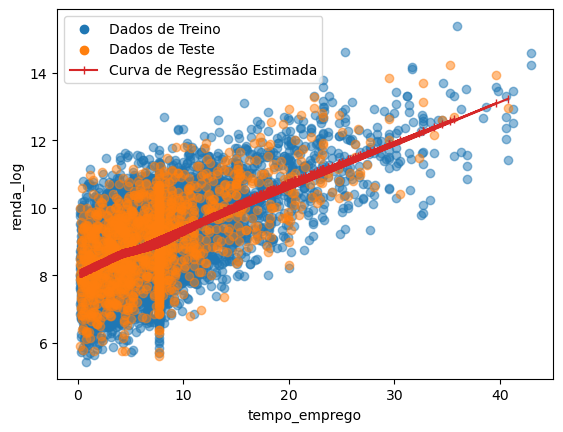

CPU times: total: 1.5 s
Wall time: 318 ms


In [41]:
%%time

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.scatter(x=df_train.tempo_emprego, y=df_train.renda_log, color=colors[0], alpha=.5)
plt.scatter([], [], color=colors[0], label="Dados de Treino")
plt.scatter(x=df_test.tempo_emprego, y=df_test.renda_log, color=colors[1], alpha=.5)
plt.scatter([], [], color=colors[1], label="Dados de Teste")
plt.plot(df_test.tempo_emprego, reg_lowess.predict(df_test), "|-", color=colors[3], label="Curva de Regressão Estimada")

plt.xlabel("tempo_emprego")
plt.ylabel("renda_log")

plt.legend()
plt.show()

In [42]:
print("{:.2%}".format(r2_score(y_true=df_test.renda_log, y_pred=reg_lowess.predict(df_test))))

37.33%


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

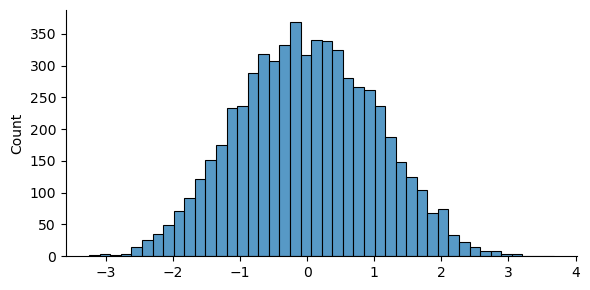

In [43]:
sns.displot(data=reg_lowess.resid, height=3, aspect=2)

plt.show()

Os resíduos exibidos no histograma parecem seguir uma distribuição aproximadamente normal, já que apresentam um formato simétrico em torno de zero, com a maioria dos valores concentrados perto da média e caindo gradualmente nas extremidades. Esse padrão é típico de uma distribuição normal.

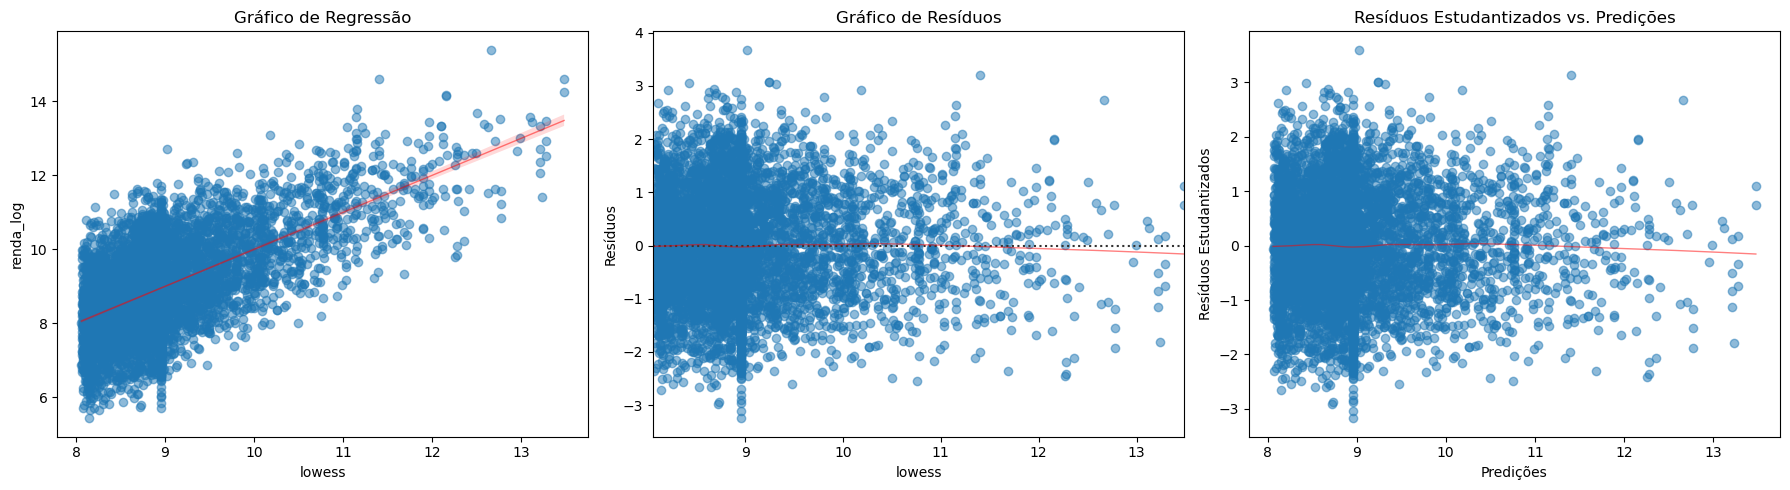

CPU times: total: 1min 9s
Wall time: 12.1 s


In [44]:
%%time

fig, ax = plt.subplots(ncols=3, figsize=(18,5))

sns.regplot(ax=ax[0], 
            data=df_train, 
            x="lowess", 
            y="renda_log", 
            scatter_kws={"alpha":.5},
            line_kws={"color":"red", "lw":1, "alpha":.5})

ax[0].set_title("Gráfico de Regressão")
ax[0].set_xlabel("lowess")
ax[0].set_ylabel("renda_log")

sns.residplot(ax=ax[1], 
              data=df_train, 
              x="lowess", 
              y="renda_log", 
              lowess=True,  
              scatter_kws={"alpha":.5}, 
              line_kws={"color":"red", "lw":1, "alpha":.5})

ax[1].set_title("Gráfico de Resíduos")
ax[1].set_xlabel("lowess")
ax[1].set_ylabel("Resíduos")

sns.regplot(ax=ax[2], 
            x=reg_lowess.predict(),
            y=reg_lowess.outlier_test().student_resid,
            scatter_kws={"alpha":.5}, 
            line_kws={"color":"red", "lw":1, "alpha":.5}, 
            lowess=True)

ax[2].set_title("Resíduos Estudantizados vs. Predições")
ax[2].set_xlabel("Predições")
ax[2].set_ylabel("Resíduos Estudantizados")

plt.tight_layout()
plt.show()

In [45]:
reg_multi = smf.ols(formula="renda_log ~ lowess + tipo_renda + posse_de_imovel", data=df_train).fit()

reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     618.9
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:57:50   Log-Likelihood:                -8581.8
No. Observations:                6000   AIC:                         1.718e+04
Df Residuals:                    5993   BIC:                         1.722e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0651      0.156     -0.418      0.676      -0.370       0.240
tipo_renda[T.Bolsista]            -0.6114      0.585     -1.046      0.296      -1.758       0.535
tipo_renda[T.Empresário]           0.1460      0.033      4.423      0.000       0.081       0.211
tipo_renda[T.Pensionista]         -0.2318      0.037     -6.270      0.000      -0.304      -0.159
tipo_renda[T.Servidor público]     0.1935      0.048      4.064      0.000       0.100       0.287
posse_de_imovel[T.S]               0.2034      0.028      7.345      0.000       0.149       0.258
lowess                             0.9910      0.017     58.360      0.000       0.958       1.024
==============================================================================
Omnibus:                       45.465   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.333
Skew:                           0.033   Prob(JB):                     1.57e-07
Kurtosis:                       2.652   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
outlier_test = reg_multi.outlier_test()

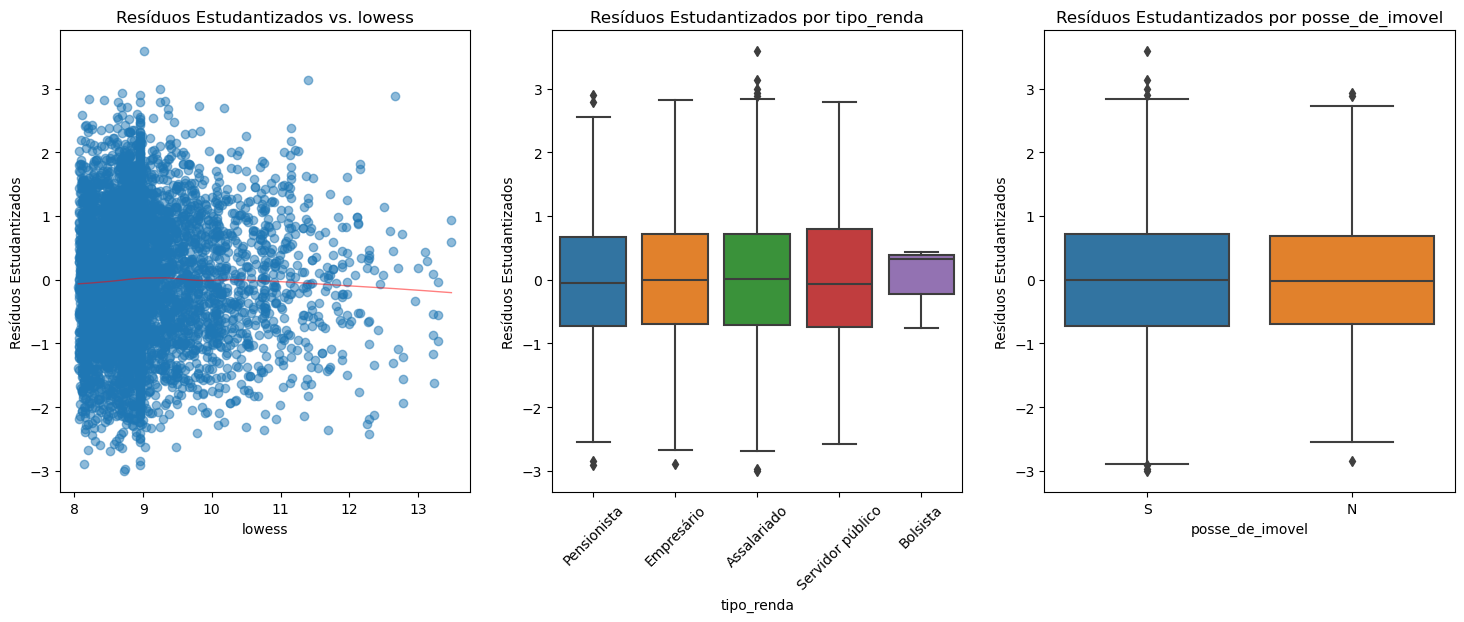

CPU times: total: 3.48 s
Wall time: 2.17 s


In [47]:
%%time

fig, ax = plt.subplots(ncols=3, figsize=(18,6))

sns.regplot(ax=ax[0], x=df_train.lowess, y=outlier_test.student_resid, lowess=True, 
            scatter_kws={"alpha":.5}, line_kws={"color":"red", "lw":1, "alpha":.5})

ax[0].set_title("Resíduos Estudantizados vs. lowess")
ax[0].set_xlabel("lowess")
ax[0].set_ylabel("Resíduos Estudantizados")

sns.boxplot(ax=ax[1], x=df_train.tipo_renda, y=outlier_test.student_resid)
ax[1].set_title("Resíduos Estudantizados por tipo_renda")
ax[1].set_xlabel("tipo_renda")
ax[1].set_ylabel("Resíduos Estudantizados")
ax[1].tick_params(axis="x", rotation=45)

sns.boxplot(ax=ax[2], x=df_train.posse_de_imovel, y=outlier_test.student_resid)
ax[2].set_title("Resíduos Estudantizados por posse_de_imovel")
ax[2].set_xlabel("posse_de_imovel")
ax[2].set_ylabel("Resíduos Estudantizados")

plt.show()

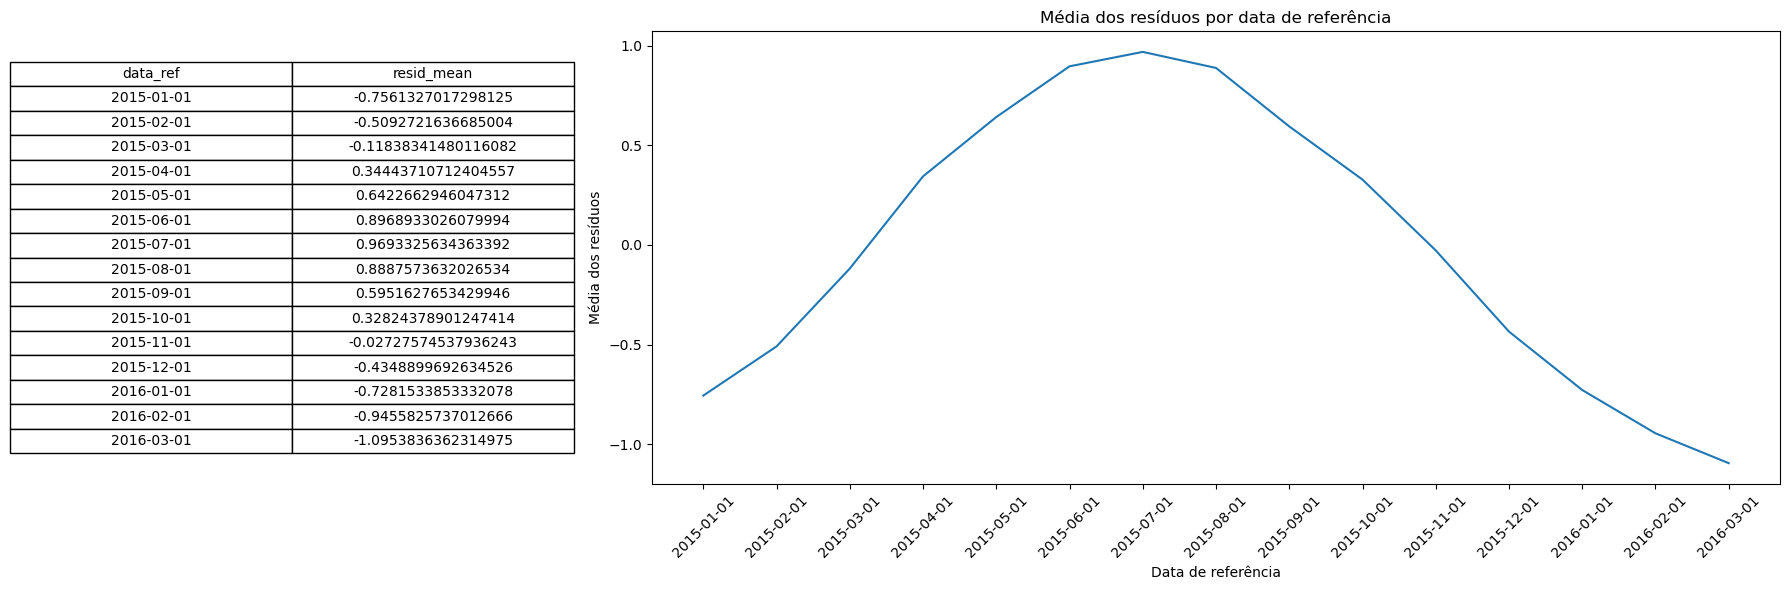

In [48]:
df_resid = pd.merge(left=df_train[["data_ref"]], right=pd.Series(data=reg_multi.resid, name="resid"), left_index=True, right_index=True, how="left")
df_resid_mean = df_resid.groupby(by="data_ref")["resid"].mean().reset_index().rename(columns={"resid":"resid_mean"})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={"width_ratios": [1, 2]})

ax1.axis("off")
table = ax1.table(cellText=df_resid_mean.values, colLabels=df_resid_mean.columns, cellLoc="center", loc="center")
table.scale(1,1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

sns.lineplot(data=df_resid_mean, x="data_ref", y="resid_mean", ax=ax2)
ax2.set_title("Média dos resíduos por data de referência")
ax2.set_xlabel("Data de referência")
ax2.set_ylabel("Média dos resíduos")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

> As suposições do modelo não estão totalmente atendidas. Observamos o seguinte:  
> 1. **Distribuição dos Resíduos**: Os resíduos (diferença entre valores reais e previstos) têm uma forma que sugere uma distribuição normal, o que é bom.  
> 2. **Gráfico de Resíduos**: A dispersão dos resíduos mostra alguns problemas. Parece que a variância dos resíduos não é constante em todas as predições, o que pode indicar heterocedasticidade (variação não constante).  
> 3. **Relação com a Data de Referência**: Existe uma relação clara entre os resíduos e a data de referência. Isso sugere que o modelo não está capturando bem a variação temporal, o que pode afetar a precisão das previsões.  
>> Em resumo, o modelo pode precisar de ajustes para lidar melhor com a variação ao longo do tempo e para garantir que a variância dos resíduos seja constante.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

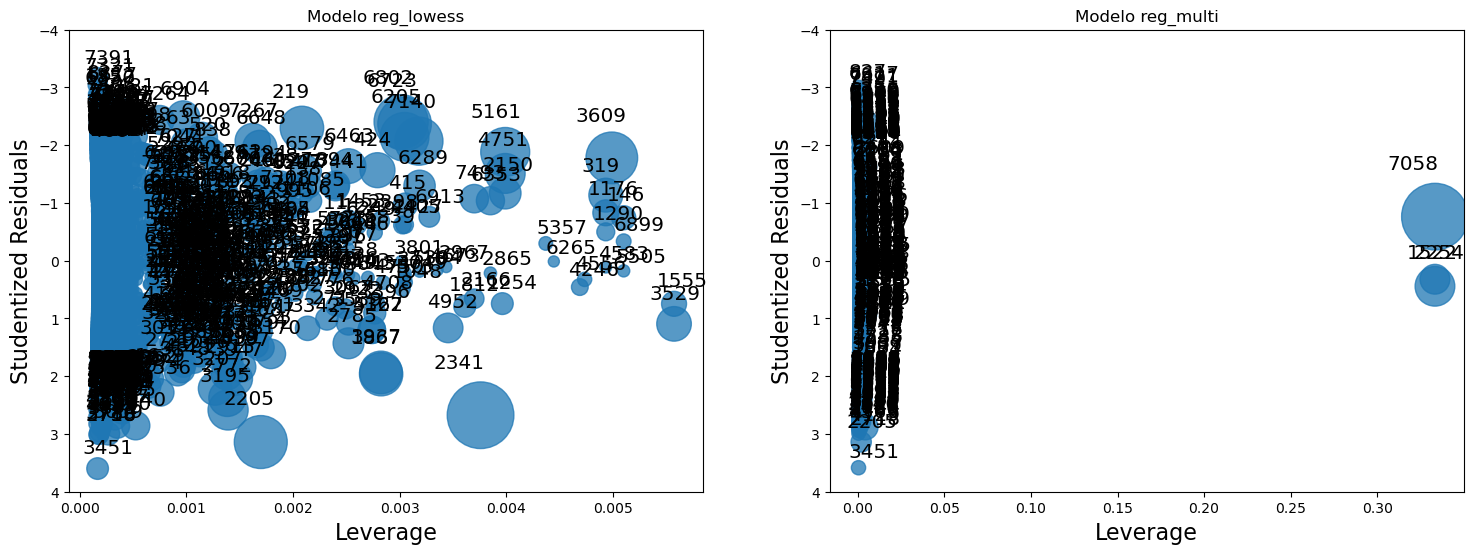

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

sm.graphics.influence_plot(results=reg_lowess, criterion="cooks", ax=ax[0])
ax[0].set_title("Modelo reg_lowess")
ax[0].set_ylim(np.ceil(np.max(reg_lowess.get_influence().resid_studentized_internal)), np.floor(np.min(reg_lowess.get_influence().resid_studentized_internal)))

sm.graphics.influence_plot(results=reg_multi, criterion="cooks", ax=ax[1])
ax[1].set_title("Modelo reg_multi")
ax[1].set_ylim(np.ceil(np.max(reg_multi.get_influence().resid_studentized_internal)), np.floor(np.min(reg_multi.get_influence().resid_studentized_internal)))

plt.show()

In [50]:
display(df_train.groupby(["tipo_renda", "posse_de_imovel"]).size().to_frame(name="qtd"))
df_train["leverage"] = reg_multi.get_influence().hat_matrix_diag
display(df_train[df_train.leverage > .2])
display(df_train[df_train.leverage > .2].groupby(by=["tipo_renda", "posse_de_imovel"]).size().to_frame("qtd"))

qtd
tipo_renda       posse_de_imovel      
Assalariado      N                1112
                 S                1980
Bolsista         S                   3
Empresário       N                 456
                 S                 909
Pensionista      N                 257
                 S                 743
Servidor público N                 210
                 S                 330

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,lowess,leverage
1522,2015-04-01,592,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,10200.21,9.230164,9.421858,0.333333
2254,2015-05-01,591,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,9221.76,9.129321,9.421858,0.333333
7058,2016-03-01,590,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,3766.03,8.233777,9.421858,0.333333


,,qtd
tipo_renda,posse_de_imovel,
Bolsista,S,3


In [51]:
df_train = df_train[df_train["tipo_renda"] != "Bolsista"].copy()
df_test = df_test[df_test["tipo_renda"] != "Bolsista"].copy()
df_train["student_resid"] = outlier_test.student_resid
df_train = df_train[(df_train["student_resid"] < 2) & (df_train["student_resid"] > -2)]

print(df_train.shape)
print(df_test.shape)

(5759, 18)
(1500, 16)


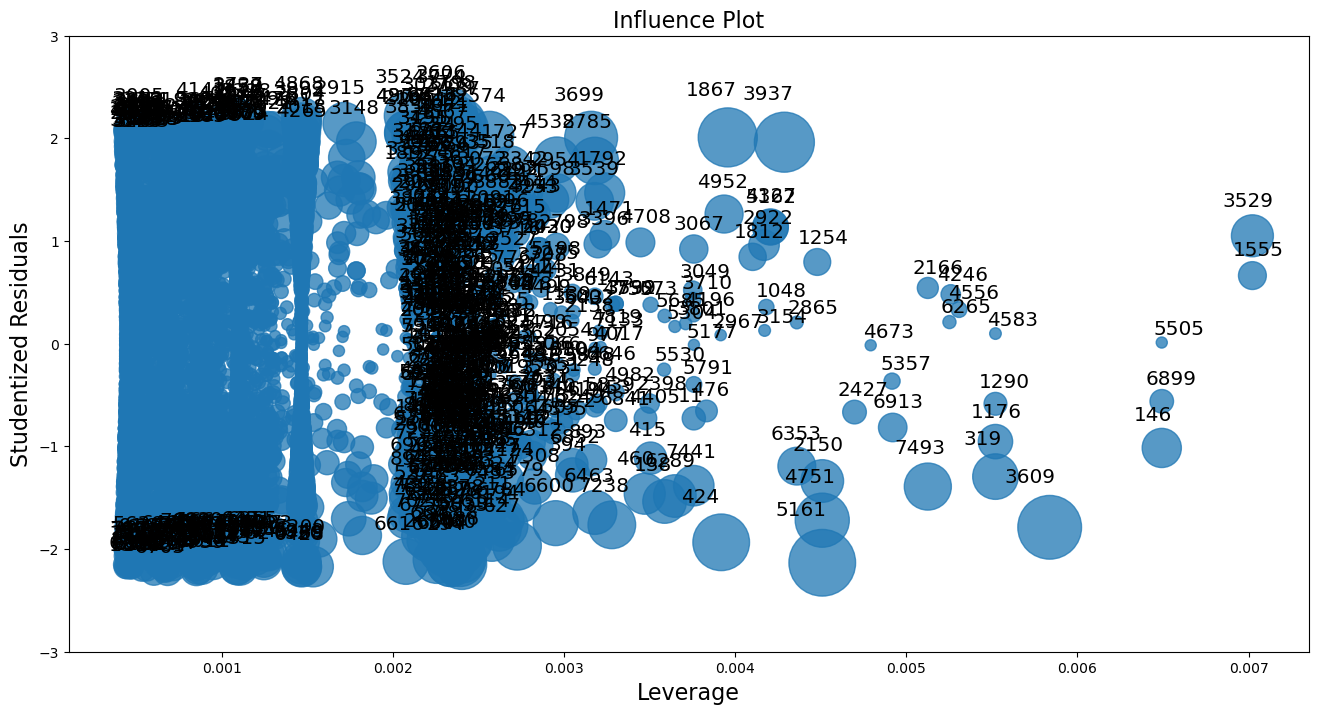

In [52]:
fig, ax = plt.subplots(figsize=(16,8))
sm.graphics.influence_plot(results=smf.ols(formula="renda_log ~ lowess + tipo_renda + posse_de_imovel", data=df_train).fit(), criterion="cooks", ax=ax)
plt.ylim(-3, 3)

plt.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

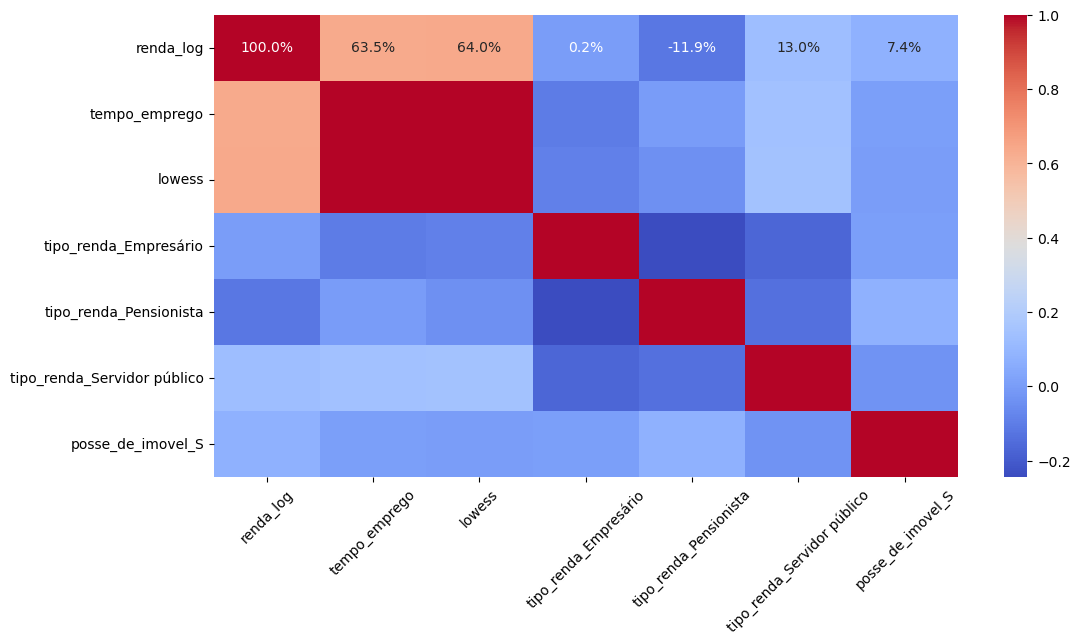

In [53]:
plt.figure(figsize=(12, 6))

sns.heatmap(pd.get_dummies(data=df_train[["renda_log", "tempo_emprego", "lowess", "tipo_renda", "posse_de_imovel"]], drop_first=True).corr(method="pearson"),
            annot=True,
            fmt=".1%",
            cmap="coolwarm")

plt.xticks(rotation=45)

plt.show()

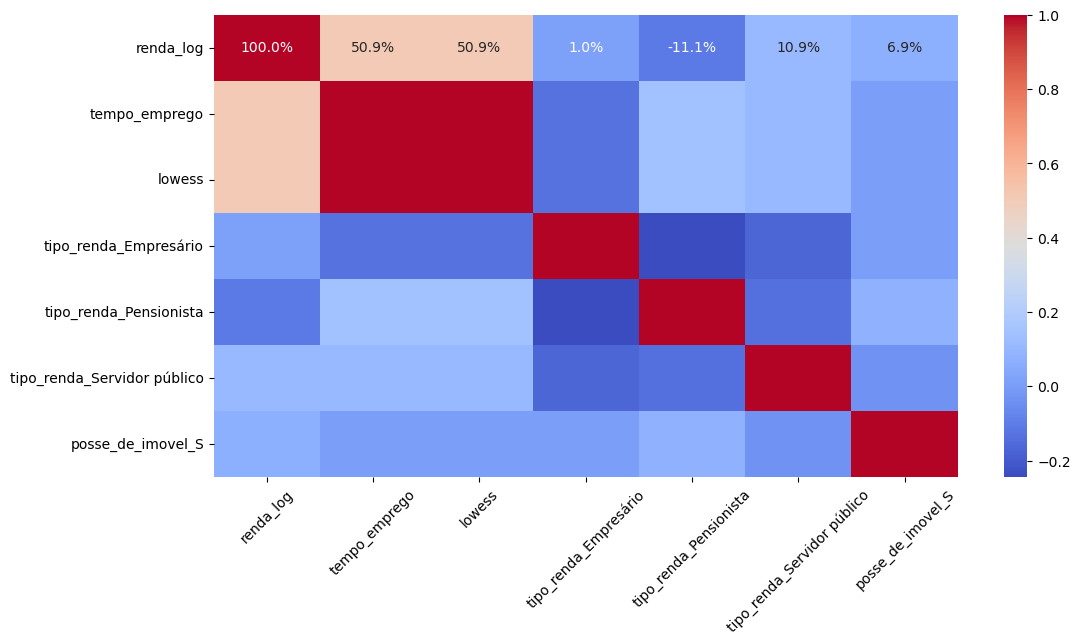

In [54]:
plt.figure(figsize=(12, 6))

sns.heatmap(pd.get_dummies(data=df_train[["renda_log", "tempo_emprego", "lowess", "tipo_renda", "posse_de_imovel"]], drop_first=True).corr(method="spearman"),
            annot=True,
            fmt=".1%",
            cmap="coolwarm")

plt.xticks(rotation=45)

plt.show()

In [55]:
columns = ["tempo_emprego", "posse_de_imovel", "tipo_renda"]
df_train_dummies = pd.get_dummies(data=df_train[columns], drop_first=True, dtype=int)
df_vif = pd.DataFrame()
df_vif["VIF Factor"] = [vif(df_train_dummies, i) for i in range(df_train_dummies.shape[1])]
df_vif["Feature"] = df_train_dummies.columns

df_vif.round(2)

,VIF Factor,Feature
0,1.90,tempo_emprego
1,1.99,posse_de_imovel_S
2,1.26,tipo_renda_Empresário
3,1.25,tipo_renda_Pensionista
4,1.16,tipo_renda_Servidor público


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

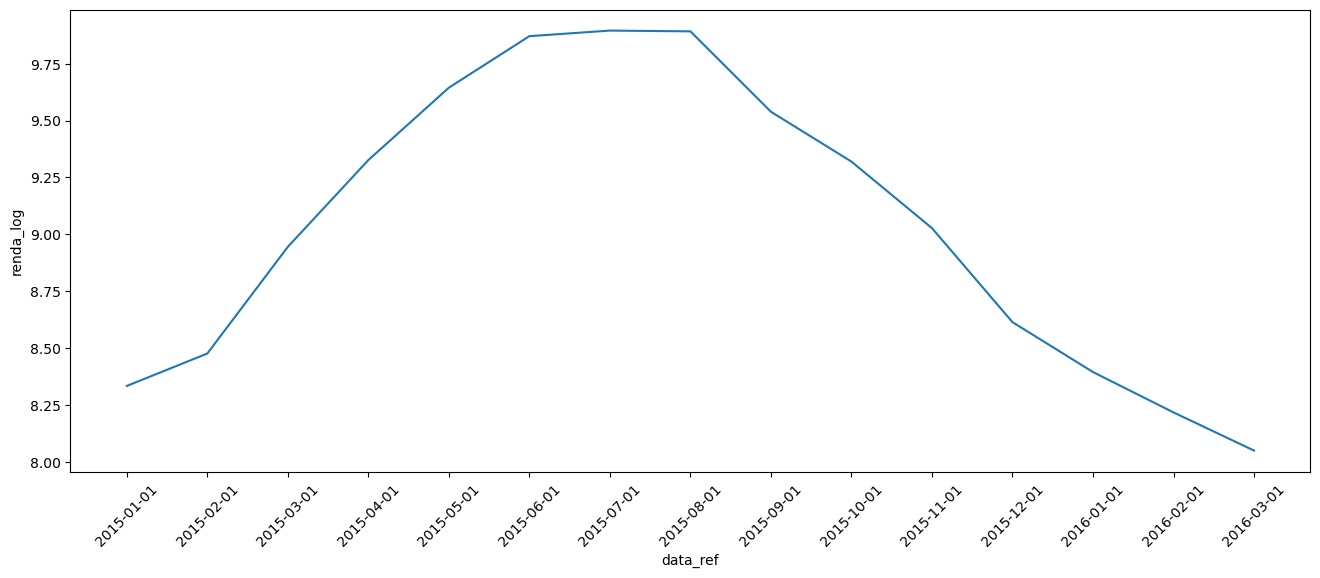

In [56]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df_train.groupby(by="data_ref").renda_log.mean())
plt.xticks(rotation=45)

plt.show()

In [57]:
df_train["renda_log_data_ref"] = df_train.renda_log - df_train.data_ref.map(df_train["renda_log"].groupby(by=df_train.data_ref).mean())

df_train

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,lowess,leverage,student_resid,renda_log_data_ref
543,2015-02-01,11415,F,N,S,0,Pensionista,Médio,Casado,Casa,65,7.666518,2.0,2468.74,7.811463,8.959169,0.001049,-0.963003,-0.664801
1526,2015-04-01,12834,F,N,S,1,Empresário,Médio,Solteiro,Casa,31,1.783562,2.0,5960.13,8.692848,8.296036,0.000920,0.184630,-0.633531
4680,2015-10-01,5510,F,N,S,0,Assalariado,Superior completo,Separado,Casa,41,9.016438,1.0,21684.23,9.984341,9.154541,0.000423,0.764383,0.664663
6868,2016-02-01,7308,F,N,S,0,Pensionista,Médio,Casado,Casa,61,7.666518,2.0,2433.88,7.797242,8.959169,0.001049,-0.977064,-0.420302
891,2015-02-01,2215,F,N,S,0,Assalariado,Médio,Casado,Casa,44,15.936986,2.0,6074.95,8.711929,10.209409,0.000793,-1.526836,0.235665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,2015-10-01,6165,F,N,S,0,Assalariado,Médio,Casado,Casa,47,6.830137,2.0,5298.50,8.575179,8.870658,0.000430,-0.350230,-0.744499
4671,2015-10-01,5210,M,S,S,0,Pensionista,Médio,Casado,Casa,58,7.666518,2.0,13043.06,9.476011,8.959169,0.001049,0.682606,0.156333
4486,2015-09-01,2818,F,N,S,0,Assalariado,Superior completo,Viúvo,Casa,47,0.389041,1.0,2825.32,7.946377,8.087538,0.000686,-0.204678,-1.592377
5192,2015-11-01,7026,F,N,S,0,Empresário,Médio,Casado,Casa,53,4.797260,2.0,6944.02,8.845636,8.699864,0.000828,-0.059945,-0.181672


In [58]:
reg_ajuste = smf.ols(formula="renda_log_data_ref ~ tempo_emprego + C(tipo_renda) + C(posse_de_imovel)", data=df_train).fit()

reg_ajuste.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     renda_log_data_ref   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1510.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:58:38   Log-Likelihood:                -5970.5
No. Observations:                5759   AIC:                         1.195e+04
Df Residuals:                    5753   BIC:                         1.199e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.1245      0.021    -53.227      0.000      -1.166      -1.083
C(tipo_renda)[T.Empresário]           0.1349      0.023      5.946      0.000       0.090       0.179
C(tipo_renda)[T.Pensionista]         -0.2835      0.025    -11.167      0.000      -0.333      -0.234
C(tipo_renda)[T.Servidor público]     0.1440      0.033      4.370      0.000       0.079       0.209
C(posse_de_imovel)[T.S]               0.2045      0.019     10.720      0.000       0.167       0.242
tempo_emprego                         0.1291      0.002     83.726      0.000       0.126       0.132
==============================================================================
Omnibus:                       17.273   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.693
Skew:                          -0.017   Prob(JB):                      0.00106
Kurtosis:                       2.764   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
data_map = df_train.renda_log.groupby(df_train.data_ref).mean()
renda_log_pred = df_test.data_ref.map(data_map) + reg_ajuste.predict(df_test)
r2 = r2_score(y_true=df_test.renda_log, y_pred=renda_log_pred)

print("{:.2%}".format(r2))

67.50%
